In [38]:
import math
import torch
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
#from pyro.contrib.examples.bart import load_bart_od
from pyro.contrib.forecast import ForecastingModel, Forecaster, eval_crps
from pyro.infer.reparam import LinearHMMReparam, StableReparam, SymmetricStableReparam
from pyro.ops.tensor_utils import periodic_repeat
from pyro.ops.stats import quantile
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
assert pyro.__version__.startswith('1.9.1')
pyro.set_rng_seed(20200305)


In [39]:
games_df = pd.read_csv('../processed_data/games_filtered.csv')

In [40]:
games_df['home_team_name']

0            Bears
1            Bills
2       Buccaneers
3         Patriots
4         Steelers
           ...    
2555       Jaguars
2556          Rams
2557        Ravens
2558        Texans
2559      Seahawks
Name: home_team_name, Length: 2560, dtype: object

In [41]:
games_df.drop(columns = ['weekly_attendance_ratio'], inplace=True)

In [42]:
home_df = games_df.loc[(games_df['home_team_name'] == 'Giants')]

In [43]:
home_df

,year,home_team_name,date,weekly_attendance,prev_game_attendance,home_team_superbowl_winner_last_season,away_team_superbowl_winner_last_season,home_team_playoffs_last_season,away_team_playoffs_last_season,home_team_wins_last_3,...,zscore_turnovers_away,day_sin,day_cos,month_sin,month_cos,noon,mid_afternoon,late_afternoon,evening,avg_season_attendance_prev
8,2010,Giants,September 12,77245.0,78809.0,False,False,False,False,1.0,...,1.519425,-0.781831,0.62349,0.000000,1.000000,True,False,False,False,78701.875
32,2010,Giants,September 26,78386.0,77245.0,False,False,False,False,1.0,...,-1.445802,-0.781831,0.62349,0.000000,1.000000,True,False,False,False,78701.875
60,2010,Giants,October 3,77716.0,78386.0,False,False,False,False,1.0,...,0.471084,-0.781831,0.62349,0.951057,0.309017,False,False,True,False,78701.875
83,2010,Giants,October 17,78341.0,77716.0,False,False,False,False,2.0,...,0.268122,-0.781831,0.62349,0.951057,0.309017,True,False,False,False,78701.875
141,2010,Giants,November 14,80851.0,78341.0,False,False,False,True,3.0,...,-0.160632,-0.781831,0.62349,0.587785,-0.809017,False,True,False,False,78701.875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2401,2019,Giants,October 20,73577.0,75041.0,False,False,False,False,1.0,...,-1.258591,-0.781831,0.62349,0.951057,0.309017,True,False,False,False,76940.625
2437,2019,Giants,November 4,76107.0,73577.0,False,False,False,True,0.0,...,0.834364,0.000000,1.00000,0.587785,-0.809017,False,False,True,False,76940.625
2483,2019,Giants,December 1,75950.0,76107.0,False,False,False,False,0.0,...,-1.097888,-0.781831,0.62349,-0.587785,-0.809017,True,False,False,False,76940.625
2515,2019,Giants,December 15,72894.0,75950.0,False,False,False,False,0.0,...,-0.346325,-0.781831,0.62349,-0.587785,-0.809017,True,False,False,False,76940.625


In [44]:
home_df[['month','day']] = home_df['date'].str.split(' ', expand=True).rename(columns={0: 'month', 1: 'day'})

C:\Users\edgar\AppData\Local\Temp\ipykernel_11776\2953458450.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  home_df[['month','day']] = home_df['date'].str.split(' ', expand=True).rename(columns={0: 'month', 1: 'day'})
C:\Users\edgar\AppData\Local\Temp\ipykernel_11776\2953458450.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  home_df[['month','day']] = home_df['date'].str.split(' ', expand=True).rename(columns={0: 'month', 1: 'day'})


In [45]:
home_df

,year,home_team_name,date,weekly_attendance,prev_game_attendance,home_team_superbowl_winner_last_season,away_team_superbowl_winner_last_season,home_team_playoffs_last_season,away_team_playoffs_last_season,home_team_wins_last_3,...,day_cos,month_sin,month_cos,noon,mid_afternoon,late_afternoon,evening,avg_season_attendance_prev,month,day
8,2010,Giants,September 12,77245.0,78809.0,False,False,False,False,1.0,...,0.62349,0.000000,1.000000,True,False,False,False,78701.875,September,12
32,2010,Giants,September 26,78386.0,77245.0,False,False,False,False,1.0,...,0.62349,0.000000,1.000000,True,False,False,False,78701.875,September,26
60,2010,Giants,October 3,77716.0,78386.0,False,False,False,False,1.0,...,0.62349,0.951057,0.309017,False,False,True,False,78701.875,October,3
83,2010,Giants,October 17,78341.0,77716.0,False,False,False,False,2.0,...,0.62349,0.951057,0.309017,True,False,False,False,78701.875,October,17
141,2010,Giants,November 14,80851.0,78341.0,False,False,False,True,3.0,...,0.62349,0.587785,-0.809017,False,True,False,False,78701.875,November,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2401,2019,Giants,October 20,73577.0,75041.0,False,False,False,False,1.0,...,0.62349,0.951057,0.309017,True,False,False,False,76940.625,October,20
2437,2019,Giants,November 4,76107.0,73577.0,False,False,False,True,0.0,...,1.00000,0.587785,-0.809017,False,False,True,False,76940.625,November,4
2483,2019,Giants,December 1,75950.0,76107.0,False,False,False,False,0.0,...,0.62349,-0.587785,-0.809017,True,False,False,False,76940.625,December,1
2515,2019,Giants,December 15,72894.0,75950.0,False,False,False,False,0.0,...,0.62349,-0.587785,-0.809017,True,False,False,False,76940.625,December,15


In [46]:
16/80

0.2

In [47]:
home_df.loc[home_df['year']>=2018]

,year,home_team_name,date,weekly_attendance,prev_game_attendance,home_team_superbowl_winner_last_season,away_team_superbowl_winner_last_season,home_team_playoffs_last_season,away_team_playoffs_last_season,home_team_wins_last_3,...,day_cos,month_sin,month_cos,noon,mid_afternoon,late_afternoon,evening,avg_season_attendance_prev,month,day
2054,2018,Giants,September 9,77992.0,76269.0,False,False,False,True,1.0,...,0.623490,0.000000,1.000000,True,False,False,False,77179.250,September,9
2109,2018,Giants,September 30,78213.0,77992.0,False,False,False,True,1.0,...,0.623490,0.000000,1.000000,False,True,False,False,77179.250,September,30
2126,2018,Giants,October 11,77167.0,78213.0,False,True,False,True,1.0,...,-0.900969,0.951057,0.309017,False,False,True,False,77179.250,October,11
2159,2018,Giants,October 28,77537.0,77167.0,False,False,False,False,0.0,...,0.623490,0.951057,0.309017,True,False,False,False,77179.250,October,28
2199,2018,Giants,November 18,75863.0,77537.0,False,False,False,False,1.0,...,0.623490,0.587785,-0.809017,True,False,False,False,77179.250,November,18
2228,2018,Giants,December 2,76465.0,75863.0,False,False,False,False,2.0,...,0.623490,-0.587785,-0.809017,True,False,False,False,77179.250,December,2
2264,2018,Giants,December 16,74538.0,76465.0,False,False,False,True,2.0,...,0.623490,-0.587785,-0.809017,True,False,False,False,77179.250,December,16
2290,2018,Giants,December 30,77750.0,74538.0,False,False,False,False,1.0,...,0.623490,-0.587785,-0.809017,True,False,False,False,77179.250,December,30
2323,2019,Giants,September 15,74569.0,77750.0,False,False,False,False,0.0,...,0.623490,0.000000,1.000000,True,False,False,False,76940.625,September,15
2357,2019,Giants,September 29,74149.0,74569.0,False,False,False,False,1.0,...,0.623490,0.000000,1.000000,True,False,False,False,76940.625,September,29


In [48]:
#pd.to_datetime(home_df[['year', 'month', 'day']])

In [49]:
games_df.columns

Index(['year', 'home_team_name', 'date', 'weekly_attendance',
       'prev_game_attendance', 'home_team_superbowl_winner_last_season',
       'away_team_superbowl_winner_last_season',
       'home_team_playoffs_last_season', 'away_team_playoffs_last_season',
       'home_team_wins_last_3', 'away_team_wins_last_3', 'pts_home',
       'pts_away', 'yds_home', 'yds_away', 'turnovers_home', 'turnovers_away',
       'zscore_pts_home', 'zscore_yds_home', 'zscore_turnovers_home',
       'zscore_pts_away', 'zscore_yds_away', 'zscore_turnovers_away',
       'day_sin', 'day_cos', 'month_sin', 'month_cos', 'noon', 'mid_afternoon',
       'late_afternoon', 'evening', 'avg_season_attendance_prev'],
      dtype='object')

In [50]:
train_df = home_df.loc[(home_df['year'] < 2018)]

In [51]:
class TransitionNet(torch.nn.Module):
    def __init__(self, cov_dim, hidden_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(cov_dim, 16)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(16, hidden_dim * hidden_dim)
        # self.softmax = torch.nn.Softmax(dim=3)
        self.hidden_dim = hidden_dim

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x= self.fc2(x)
        batch_size = x.size(0)
        
        x = x.view(batch_size, self.hidden_dim, self.hidden_dim)  # [batch, hidden_dim, hidden_dim]
        temperature = 1.5  # try values between 1 and 2
        trans_matrix = torch.nn.functional.softmax(x/ temperature, dim=-1)  # Row-wise softmax for valid transition matrices
        
        # Optional: blend with identity for numerical stability
        # trans_matrix = 0.9 * x + 0.1 * torch.eye(self.hidden_dim)
        return trans_matrix
class Model1(ForecastingModel):
    def __init__(self, cov_dim, hidden_dim=3):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.cov_dim = cov_dim
        self.trans_net = TransitionNet(cov_dim, hidden_dim)
        

    def model(self, zero_data, covariates):
        duration = zero_data.size(-2)
        
        batch_shape = zero_data.shape[:-2] 
        
        hidden_dim = self.hidden_dim
        last_year_avg_attendance = covariates[..., 0]
        other_covariates = covariates[..., 1:]

        prediction = last_year_avg_attendance.unsqueeze(-1)  # [T, 1] or [N, T, 1]
        prediction = prediction.expand_as(zero_data)
        trans_scale = pyro.sample("trans_scale", dist.LogNormal(-0.5 * math.log(24), 1))
        trans_scale = trans_scale + 1e-3
        batch_shape = trans_scale.shape[:-1]  # [N, T]
        init_dist = dist.Normal(0, 10).expand(batch_shape + (hidden_dim,)).to_event(1)
   
        trans_mean = torch.zeros_like(trans_scale)
        trans_dist = dist.Normal(trans_mean, trans_scale).expand(batch_shape + (hidden_dim,)).to_event(1)
        obs_scale = pyro.sample("obs_scale", dist.LogNormal(-2, 1))
        obs_mean = torch.zeros_like(obs_scale)
        obs_dist = dist.Normal(obs_mean, obs_scale).expand(batch_shape + (1,)).to_event(1)
        trans_logits = self.trans_net(other_covariates)  # [duration, hidden_dim * hidden_dim]
        # print(trans_logits)
        
            
        trans_matrix_raw = trans_logits.view(duration, hidden_dim, hidden_dim)
    
        trans_matrix=0.9 * trans_matrix_raw + 0.1 * torch.eye(hidden_dim)
        obs_matrix = torch.eye(hidden_dim, 1).expand(*batch_shape, hidden_dim, 1)
        
        if batch_shape:
            trans_matrix = trans_matrix.unsqueeze(0).expand((batch_shape[0], duration, hidden_dim, hidden_dim))
            obs_matrix = torch.eye(hidden_dim, 1).reshape(1, 1, hidden_dim, 1)  # e.g. [1, 1, 3, 1]
            obs_matrix = obs_matrix.expand(batch_shape[0], duration, hidden_dim, 1)  # match batch

            # loc = torch.zeros(batch_shape[0], duration, hidden_dim)
            # scale = torch.full_like(loc, 10.0)
            # init_dist = dist.Normal(loc, scale).to_event(1)
            init_loc = torch.zeros(batch_shape[0], hidden_dim)  # [100, 3]
            init_scale = torch.full((batch_shape[0], hidden_dim), 10.0)  # [100, 3]
            init_dist = dist.Normal(init_loc, init_scale).to_event(1)  # batch_shape [100]

            trans_loc = torch.zeros(batch_shape[0], duration, hidden_dim)
            trans_scale = torch.full_like(trans_loc, 1.0)  # or your current trans_scale value

            trans_dist = dist.Normal(trans_loc, trans_scale).to_event(1)

            # obs_scale = obs_scale.view(batch_shape[0], 1, 1)
            # obs_scale = obs_scale.expand((batch_shape[0], duration, 1))
            # obs_mean = torch.zeros_like(obs_scale)
            # obs_mean = obs_mean.squeeze(-1)         # shape: [100, 32]
            # obs_scale = obs_scale.squeeze(-1)     # shape: [100, 32]   
            obs_scale = obs_scale.view(batch_shape[0], 1, 1).expand(batch_shape[0], duration, 1)
            obs_mean = torch.zeros_like(obs_scale)  # shape [100, 32, 1]
            obs_dist = dist.Normal(obs_mean, obs_scale).to_event(1)  # now event_shape = (1,)
            # obs_dist = dist.Normal(obs_mean, obs_scale) # no to_event here

            print("transmatrix done")
            print("trans_matrix shape: ", trans_matrix.shape)
            print("obs_matrix shape:", obs_matrix.shape)
            print("obs_dist shape:", obs_dist.shape)
            print("init dist shape:", init_dist.shape)
            print("trans dist shape", trans_dist.shape)

        print(" ")
        print("trans_matrix shape: ",  trans_matrix.shape[:-2])
        print("obs_matrix shape:", obs_matrix.shape[:-2])
        print("obs_dist shape:", obs_dist.batch_shape)
        print("init dist shape:", init_dist.batch_shape + (1,))
        print("init_dist.event_shape:", init_dist.event_shape)
        print("trans dist shape", trans_dist.batch_shape)
        noise_dist = dist.GaussianHMM(
            initial_dist=init_dist,
            transition_matrix=trans_matrix,
            transition_dist=trans_dist,
            observation_matrix=obs_matrix,  # obs_dim = 1
            observation_dist=obs_dist,
            duration=duration
        )

        self.predict(noise_dist, prediction)


In [52]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
covariates = train_df[['avg_season_attendance_prev', 'home_team_superbowl_winner_last_season',
       'away_team_superbowl_winner_last_season',
       'home_team_playoffs_last_season', 'away_team_playoffs_last_season',
       'home_team_wins_last_3', 'away_team_wins_last_3', 'pts_home',
       'pts_away', 'yds_home', 'yds_away', 'turnovers_home', 'turnovers_away',
       'zscore_pts_home', 'zscore_yds_home', 'zscore_turnovers_home',
       'zscore_pts_away', 'zscore_yds_away', 'zscore_turnovers_away',
       'day_sin', 'day_cos', 'month_sin', 'month_cos', 'noon', 'mid_afternoon',
       'late_afternoon', 'evening']]
# print(covariates)
covariates.loc[:,['noon', 'mid_afternoon',
       'late_afternoon', 'evening', 'home_team_superbowl_winner_last_season',
       'away_team_superbowl_winner_last_season',
       'home_team_playoffs_last_season', 'away_team_playoffs_last_season']] = covariates[['noon', 'mid_afternoon',
       'late_afternoon', 'evening', 'home_team_superbowl_winner_last_season',
       'away_team_superbowl_winner_last_season',
       'home_team_playoffs_last_season', 'away_team_playoffs_last_season']].astype('int')

covariates_tensor = torch.tensor(covariates.values, dtype=torch.float)

y = train_df.loc[train_df.index, 'weekly_attendance']
y_tensor = torch.tensor(y.values, dtype=torch.float).unsqueeze(-1)

forecaster = Forecaster(Model1(cov_dim=26, hidden_dim=3), y_tensor, covariates_tensor, learning_rate=0.1, num_steps=500)
for name, value in forecaster.guide.median().items():
    if value.numel() == 1:
        print("{} = {:0.4g}".format(name, value.item()))

<timed exec>:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1 1 0 1 0 1 1 1 0 1 1 1 0 0 1 0 0 1 1 1 0 0 0 1 0 1 0 1 0 0 1 1 1 1 1 0 1
 0 1 1 1 0 0 0 0 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 1 1 1 1]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
<timed exec>:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
<timed exec>:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0
 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0]' has dtype incompatible with

 
trans_matrix shape:  torch.Size([64])
obs_matrix shape: torch.Size([])
obs_dist shape: torch.Size([])
init dist shape: torch.Size([1])
init_dist.event_shape: torch.Size([3])
trans dist shape torch.Size([])
 
trans_matrix shape:  torch.Size([64])
obs_matrix shape: torch.Size([])
obs_dist shape: torch.Size([])
init dist shape: torch.Size([1])
init_dist.event_shape: torch.Size([3])
trans dist shape torch.Size([])
 
trans_matrix shape:  torch.Size([64])
obs_matrix shape: torch.Size([])
obs_dist shape: torch.Size([])
init dist shape: torch.Size([1])
init_dist.event_shape: torch.Size([3])
trans dist shape torch.Size([])
 
trans_matrix shape:  torch.Size([64])
obs_matrix shape: torch.Size([])
obs_dist shape: torch.Size([])
init dist shape: torch.Size([1])
init_dist.event_shape: torch.Size([3])
trans dist shape torch.Size([])
 
trans_matrix shape:  torch.Size([64])
obs_matrix shape: torch.Size([])
obs_dist shape: torch.Size([])
init dist shape: torch.Size([1])
init_dist.event_shape: torch.Si

INFO 	 step  100 loss = 9.86663


 
trans_matrix shape:  torch.Size([64])
obs_matrix shape: torch.Size([])
obs_dist shape: torch.Size([])
init dist shape: torch.Size([1])
init_dist.event_shape: torch.Size([3])
trans dist shape torch.Size([])
 
trans_matrix shape:  torch.Size([64])
obs_matrix shape: torch.Size([])
obs_dist shape: torch.Size([])
init dist shape: torch.Size([1])
init_dist.event_shape: torch.Size([3])
trans dist shape torch.Size([])
 
trans_matrix shape:  torch.Size([64])
obs_matrix shape: torch.Size([])
obs_dist shape: torch.Size([])
init dist shape: torch.Size([1])
init_dist.event_shape: torch.Size([3])
trans dist shape torch.Size([])
 
trans_matrix shape:  torch.Size([64])
obs_matrix shape: torch.Size([])
obs_dist shape: torch.Size([])
init dist shape: torch.Size([1])
init_dist.event_shape: torch.Size([3])
trans dist shape torch.Size([])
 
trans_matrix shape:  torch.Size([64])
obs_matrix shape: torch.Size([])
obs_dist shape: torch.Size([])
init dist shape: torch.Size([1])
init_dist.event_shape: torch.Si

INFO 	 step  200 loss = 9.59991


 
trans_matrix shape:  torch.Size([64])
obs_matrix shape: torch.Size([])
obs_dist shape: torch.Size([])
init dist shape: torch.Size([1])
init_dist.event_shape: torch.Size([3])
trans dist shape torch.Size([])
 
trans_matrix shape:  torch.Size([64])
obs_matrix shape: torch.Size([])
obs_dist shape: torch.Size([])
init dist shape: torch.Size([1])
init_dist.event_shape: torch.Size([3])
trans dist shape torch.Size([])
 
trans_matrix shape:  torch.Size([64])
obs_matrix shape: torch.Size([])
obs_dist shape: torch.Size([])
init dist shape: torch.Size([1])
init_dist.event_shape: torch.Size([3])
trans dist shape torch.Size([])
 
trans_matrix shape:  torch.Size([64])
obs_matrix shape: torch.Size([])
obs_dist shape: torch.Size([])
init dist shape: torch.Size([1])
init_dist.event_shape: torch.Size([3])
trans dist shape torch.Size([])
 
trans_matrix shape:  torch.Size([64])
obs_matrix shape: torch.Size([])
obs_dist shape: torch.Size([])
init dist shape: torch.Size([1])
init_dist.event_shape: torch.Si

INFO 	 step  300 loss = 9.49696


 
trans_matrix shape:  torch.Size([64])
obs_matrix shape: torch.Size([])
obs_dist shape: torch.Size([])
init dist shape: torch.Size([1])
init_dist.event_shape: torch.Size([3])
trans dist shape torch.Size([])
 
trans_matrix shape:  torch.Size([64])
obs_matrix shape: torch.Size([])
obs_dist shape: torch.Size([])
init dist shape: torch.Size([1])
init_dist.event_shape: torch.Size([3])
trans dist shape torch.Size([])
 
trans_matrix shape:  torch.Size([64])
obs_matrix shape: torch.Size([])
obs_dist shape: torch.Size([])
init dist shape: torch.Size([1])
init_dist.event_shape: torch.Size([3])
trans dist shape torch.Size([])
 
trans_matrix shape:  torch.Size([64])
obs_matrix shape: torch.Size([])
obs_dist shape: torch.Size([])
init dist shape: torch.Size([1])
init_dist.event_shape: torch.Size([3])
trans dist shape torch.Size([])
 
trans_matrix shape:  torch.Size([64])
obs_matrix shape: torch.Size([])
obs_dist shape: torch.Size([])
init dist shape: torch.Size([1])
init_dist.event_shape: torch.Si

INFO 	 step  400 loss = 9.45577


 
trans_matrix shape:  torch.Size([64])
obs_matrix shape: torch.Size([])
obs_dist shape: torch.Size([])
init dist shape: torch.Size([1])
init_dist.event_shape: torch.Size([3])
trans dist shape torch.Size([])
 
trans_matrix shape:  torch.Size([64])
obs_matrix shape: torch.Size([])
obs_dist shape: torch.Size([])
init dist shape: torch.Size([1])
init_dist.event_shape: torch.Size([3])
trans dist shape torch.Size([])
 
trans_matrix shape:  torch.Size([64])
obs_matrix shape: torch.Size([])
obs_dist shape: torch.Size([])
init dist shape: torch.Size([1])
init_dist.event_shape: torch.Size([3])
trans dist shape torch.Size([])
 
trans_matrix shape:  torch.Size([64])
obs_matrix shape: torch.Size([])
obs_dist shape: torch.Size([])
init dist shape: torch.Size([1])
init_dist.event_shape: torch.Size([3])
trans dist shape torch.Size([])
 
trans_matrix shape:  torch.Size([64])
obs_matrix shape: torch.Size([])
obs_dist shape: torch.Size([])
init dist shape: torch.Size([1])
init_dist.event_shape: torch.Si

In [53]:
test_and_context_df = home_df.loc[(home_df['year'] >= 2017)]


transmatrix done
trans_matrix shape:  torch.Size([100, 24, 3, 3])
obs_matrix shape: torch.Size([100, 24, 3, 1])
obs_dist shape: <bound method TorchDistributionMixin.shape of Independent(Normal(loc: torch.Size([100, 24, 1]), scale: torch.Size([100, 24, 1])), 1)>
init dist shape: <bound method TorchDistributionMixin.shape of Independent(Normal(loc: torch.Size([100, 3]), scale: torch.Size([100, 3])), 1)>
trans dist shape <bound method TorchDistributionMixin.shape of Independent(Normal(loc: torch.Size([100, 24, 3]), scale: torch.Size([100, 24, 3])), 1)>
 
trans_matrix shape:  torch.Size([100, 24])
obs_matrix shape: torch.Size([100, 24])
obs_dist shape: torch.Size([100, 24])
init dist shape: torch.Size([100, 1])
init_dist.event_shape: torch.Size([3])
trans dist shape torch.Size([100, 24])


C:\Users\edgar\AppData\Local\Temp\ipykernel_11776\936395427.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  covariates_test.loc[:,['noon', 'mid_afternoon',
C:\Users\edgar\AppData\Local\Temp\ipykernel_11776\936395427.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  covariates_test.loc[:,['noon', 'mid_afternoon',
C:\Users\edgar\AppData\Local\Temp\ipykernel_11776\936395427.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0]' has dtype incompatib

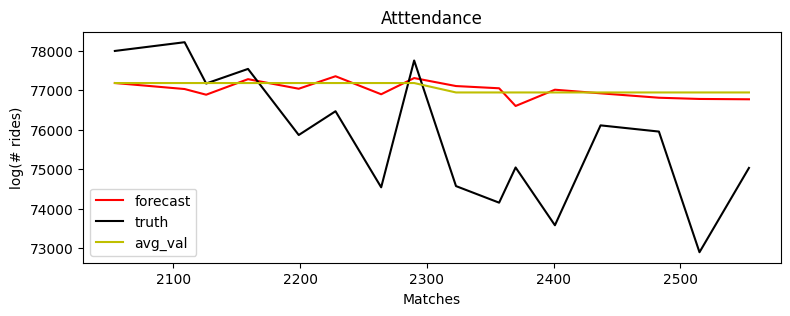

In [54]:
# covariates_test_with_test = torch.zeros(T2-T0, 0)  # empty
covariates_test = test_and_context_df[['avg_season_attendance_prev', 'home_team_superbowl_winner_last_season',
       'away_team_superbowl_winner_last_season',
       'home_team_playoffs_last_season', 'away_team_playoffs_last_season',
       'home_team_wins_last_3', 'away_team_wins_last_3', 'pts_home',
       'pts_away', 'yds_home', 'yds_away', 'turnovers_home', 'turnovers_away',
       'zscore_pts_home', 'zscore_yds_home', 'zscore_turnovers_home',
       'zscore_pts_away', 'zscore_yds_away', 'zscore_turnovers_away',
       'day_sin', 'day_cos', 'month_sin', 'month_cos', 'noon', 'mid_afternoon',
       'late_afternoon', 'evening']]
# print(covariates_test)
covariates_test.loc[:,['noon', 'mid_afternoon',
       'late_afternoon', 'evening', 'home_team_superbowl_winner_last_season',
       'away_team_superbowl_winner_last_season',
       'home_team_playoffs_last_season', 'away_team_playoffs_last_season']] = covariates_test[['noon', 'mid_afternoon',
       'late_afternoon', 'evening', 'home_team_superbowl_winner_last_season',
       'away_team_superbowl_winner_last_season',
       'home_team_playoffs_last_season', 'away_team_playoffs_last_season']].astype('int')

covariates_test_tensor = torch.tensor(covariates_test.values, dtype=torch.float)

y_context = test_and_context_df.loc[test_and_context_df['year']<2018, 'weekly_attendance']
y_context_tensor = torch.tensor(y_context.values, dtype=torch.float).unsqueeze(-1)
samples = forecaster(y_context_tensor, covariates_test_tensor, num_samples=100)
# samples.clamp_(min=0)  # apply domain knowledge: the samples must be positive
p10, p50, p90 = quantile(samples, (0.1, 0.5, 0.9)).squeeze(-1)
y_test = test_and_context_df.loc[test_and_context_df['year']>=2018, 'weekly_attendance']
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float).unsqueeze(-1)
crps = eval_crps(samples, y_test_tensor)

plt.figure(figsize=(9, 3))
# plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
plt.plot(y_test.index, p50, 'r-', label='forecast')
plt.plot(y_test.index, y_test.values, 'k-', label='truth')
plt.plot(y_test.index, covariates_test.loc[y_test.index,'avg_season_attendance_prev'].values, 'y', label='avg_val')
plt.title("Atttendance")
plt.ylabel("log(# rides)")
plt.xlabel("Matches")
plt.legend(loc="best")


In [55]:
y_test.shape

(16,)

In [56]:
y_test.shape

(16,)

In [57]:
print(home_df.loc[home_df['year']==2017, 'weekly_attendance'].values.mean())
home_df.loc[home_df['year']==2018, 'avg_season_attendance_prev']

77179.25


2054    77179.25
2109    77179.25
2126    77179.25
2159    77179.25
2199    77179.25
2228    77179.25
2264    77179.25
2290    77179.25
Name: avg_season_attendance_prev, dtype: float64

In [58]:
att_df = pd.read_csv('../original_data/attendance.csv')    

In [59]:
att_df.loc[att_df['team_name'] == 'Cardinals']

,team,team_name,year,total,home,away,week,weekly_attendance
0,Arizona,Cardinals,2000,893926,387475,506451,1,77434.0
1,Arizona,Cardinals,2000,893926,387475,506451,2,66009.0
2,Arizona,Cardinals,2000,893926,387475,506451,3,NaN
3,Arizona,Cardinals,2000,893926,387475,506451,4,71801.0
4,Arizona,Cardinals,2000,893926,387475,506451,5,66985.0
...,...,...,...,...,...,...,...,...
10314,Arizona,Cardinals,2019,1000509,490586,509923,13,60944.0
10315,Arizona,Cardinals,2019,1000509,490586,509923,14,63880.0
10316,Arizona,Cardinals,2019,1000509,490586,509923,15,63345.0
10317,Arizona,Cardinals,2019,1000509,490586,509923,16,69022.0


In [60]:
games_df

,year,home_team_name,date,weekly_attendance,prev_game_attendance,home_team_superbowl_winner_last_season,away_team_superbowl_winner_last_season,home_team_playoffs_last_season,away_team_playoffs_last_season,home_team_wins_last_3,...,zscore_turnovers_away,day_sin,day_cos,month_sin,month_cos,noon,mid_afternoon,late_afternoon,evening,avg_season_attendance_prev
0,2010,Bears,September 12,62080.0,62479.0,False,False,False,False,2.0,...,0.268122,-0.781831,0.62349,0.000000,1.000000,True,False,False,False,62250.000
1,2010,Bills,September 12,69295.0,69848.0,False,False,False,False,1.0,...,-1.196211,-0.781831,0.62349,0.000000,1.000000,True,False,False,False,67808.125
2,2010,Buccaneers,September 12,47211.0,62578.0,False,False,False,False,2.0,...,0.696191,-0.781831,0.62349,0.000000,1.000000,True,False,False,False,65649.250
3,2010,Patriots,September 12,68756.0,68756.0,False,False,False,True,2.0,...,0.346325,-0.781831,0.62349,0.000000,1.000000,True,False,False,False,68756.000
4,2010,Steelers,September 12,63609.0,64068.0,False,False,False,False,3.0,...,-0.514384,-0.781831,0.62349,0.000000,1.000000,True,False,False,False,63485.250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2555,2019,Jaguars,December 29,58472.0,57866.0,False,False,False,True,1.0,...,0.412861,-0.781831,0.62349,-0.587785,-0.809017,False,True,False,False,69073.625
2556,2019,Rams,December 29,68665.0,71501.0,False,False,False,False,1.0,...,2.337384,-0.781831,0.62349,-0.587785,-0.809017,False,True,False,False,72429.875
2557,2019,Ravens,December 29,70695.0,70545.0,False,False,False,False,3.0,...,0.230361,-0.781831,0.62349,-0.587785,-0.809017,False,True,False,False,70431.375
2558,2019,Texans,December 29,71794.0,71769.0,False,False,False,False,2.0,...,-0.980426,-0.781831,0.62349,-0.587785,-0.809017,False,True,False,False,71804.875


In [61]:
print(y_test)

2054    77992.0
2109    78213.0
2126    77167.0
2159    77537.0
2199    75863.0
2228    76465.0
2264    74538.0
2290    77750.0
2323    74569.0
2357    74149.0
2370    75041.0
2401    73577.0
2437    76107.0
2483    75950.0
2515    72894.0
2554    75029.0
Name: weekly_attendance, dtype: float64


In [62]:
test_df

NameError: name 'test_df' is not defined

In [ ]:
class Model1(ForecastingModel):
    def __init__(self, cov_dim, hidden_dim=3):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.cov_dim = cov_dim
        self.trans_net = TransitionNet(cov_dim, hidden_dim)

    def model(self, zero_data, covariates):
        duration = zero_data.size(-2)
        batch_shape = zero_data.shape[:-2]  # This should be [100] when sampling
        
        hidden_dim = self.hidden_dim
        last_year_avg_attendance = covariates[..., 0]
        other_covariates = covariates[..., 1:]
        
        # Mean function - ensure proper broadcasting
        prediction = last_year_avg_attendance.unsqueeze(-1).expand_as(zero_data)
        print(batch_shape)
        print("zero_data shape:", zero_data.shape)
        # Priors - allp expanded to batch_shape + hidden_dim
        init_dist = dist.Normal(0, 10).expand(batch_shape + (hidden_dim,)).to_event(1)
        
        # Sample with proper batch_shape
        trans_scale = pyro.sample(
            "trans_scale", 
            dist.LogNormal(-0.5 * math.log(24), 1)
            .expand(batch_shape)
        ).unsqueeze(-1)  # Add hidden_dim dimension
        
        trans_dist = dist.Normal(
            torch.zeros(batch_shape + (hidden_dim,)),
            trans_scale.expand(batch_shape + (hidden_dim,))
        ).to_event(1)
        
        obs_scale = pyro.sample(
            "obs_scale",
            dist.LogNormal(-2, 1)
            .expand(batch_shape)
        ).unsqueeze(-1)  # Add observation dimension
        
        obs_dist = dist.Normal(
            torch.zeros(batch_shape + (1,)),
            obs_scale
        ).to_event(1)

        # Generate transition matrices - handle batch dimension properly
        # Reshape covariates to merge sample and time dimensions
        orig_shape = other_covariates.shape
        other_covariates_reshaped = other_covariates.reshape(-1, orig_shape[-1])
        
        # Process through network
        trans_logits = self.trans_net(other_covariates_reshaped)
        
        # Reshape back to include sample dimension
        trans_matrix = trans_logits.reshape(*batch_shape, duration, hidden_dim, hidden_dim)
        
        # Stability adjustment
        eye = torch.eye(hidden_dim, device=trans_matrix.device)
        trans_matrix = 0.9 * trans_matrix + 0.1 * eye
        
        # Observation matrix - properly expanded
        obs_matrix = torch.eye(hidden_dim, 1, device=trans_matrix.device)
        obs_matrix = obs_matrix.expand(*batch_shape, hidden_dim, 1)
        
        # Build GaussianHMM
        noise_dist = dist.GaussianHMM(
            initial_dist=init_dist,
            transition_matrix=trans_matrix,
            transition_dist=trans_dist,
            observation_matrix=obs_matrix,
            observation_dist=obs_dist,
            duration=duration
        )

        self.predict(noise_dist, prediction)

In [ ]:
a = torch.tensor([1.0013e-01, 8.9934e-01, 5.3601e-04])
a.sum()

tensor(1.0000)

In [ ]:
torch.softmax(torch.tensor([0.9, -0.1, 4.0]), dim=0)

tensor([0.0424, 0.0156, 0.9420])